# Imports and global inits


In [ ]:
!pip install qiskit
!pip install qiskit_algorithms
!pip install qiskit_nature[pyscf] -U
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RXGate, RYGate, RZGate, CZGate
from qiskit.circuit import Parameter, ParameterVector, Instruction
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.units import DistanceUnit
from qiskit.quantum_info import Pauli, PauliList, Operator
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from sympy import Symbol
from qiskit.circuit.quantumregister import Qubit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

converter= JordanWignerMapper()

# Set hyperparameters
start_distance = 0.5
end_distance = 2.0
step_distance = 0.1
num_layers = 5
num_epochs = 100
batch_size = 32
learning_rate = 0.01



## Defining Operator pool

In [ ]:
# Define the operator pool and time evolution parameters
def operator_pool(num_qubits):
    pauli_strings = ['I', 'X', 'Y', 'Z']
    rotation_gates = ['RX', 'RY', 'RZ']
    single_qubit_gates = ['H']  # Add Hadamard gate to the pool
    pool = []
    for i in range(num_qubits):
        for pauli in pauli_strings:
            if pauli == 'I':
                pool.append(Pauli('I' * num_qubits))
            else:
                pauli_label = 'I' * i + pauli + 'I' * (num_qubits - i - 1)
                pool.append(Pauli(pauli_label))
        for gate in rotation_gates:
            pool.append((gate, i))
        for gate in single_qubit_gates:
            pool.append((gate, i))  # Add Hadamard gate for each qubit
    for control in range(num_qubits):
        for target in range(num_qubits):
            if control != target:
                pool.append(('CNOT', control, target))
    return pool
time_params = [np.pi / 2, np.pi / 4, np.pi / 8, np.pi / 16]

# Circuit Generation based on sequence

In [ ]:
# Define the function to generate a circuit from a sequence
def generate_circuit(num_qubits, sequence):
    qc = QuantumCircuit(num_qubits)
    parameters = ParameterVector('theta', len(sequence))
    pool_size = len(operator_pool(num_qubits))
    for i, item_tuple in enumerate(sequence):
        item_idx = item_tuple[0] % pool_size  # Wrap item_idx within the valid range
        item = operator_pool(num_qubits)[item_idx]
        if isinstance(item, Pauli):
            qc.append(item.to_instruction(), qargs=range(num_qubits))
            qc.rz(parameters[i], range(num_qubits))
        elif len(item) == 2:
            gate, qubit = item
            if gate == 'RX':
                qc.rx(parameters[i], qubit)
            elif gate == 'RY':
                qc.ry(parameters[i], qubit)
            elif gate == 'RZ':
                qc.rz(parameters[i], qubit)
            elif gate == 'H':
                qc.h(qubit)
        elif len(item) == 3:
            gate, control, target = item
            if gate == 'CNOT':
                qc.cx(control, target)
    return qc

# Quantum Transformer Utilities

## Matrix Data Loader

In [ ]:
def matrix_data_loader(qc, matrix):
    num_rows, num_cols = matrix.shape
    num_qubits = qc.num_qubits

    # Determine the number of qubits needed for each register
    num_row_qubits = int(np.ceil(np.log2(num_rows)))
    num_col_qubits = int(np.ceil(np.log2(num_cols)))

    # Create quantum registers for rows and columns
    row_register = QuantumRegister(num_row_qubits, name='row')
    col_register = QuantumRegister(num_col_qubits, name='col')

    # Add the registers to the quantum circuit
    qc.add_register(row_register)
    qc.add_register(col_register)

    # Load the norms of each row into the row register
    row_norms = np.linalg.norm(matrix, axis=1)
    load_vector(qc, row_norms, row_register)

    # Load each row of the matrix into the column register
    for i in range(num_rows):
        # Load the i-th row into the column register
        load_vector(qc, matrix[i], col_register, inverse=False)

        # Apply controlled operations to entangle the row and column registers
        if num_col_qubits > 0:
            control_qubit = min(i, num_row_qubits - 1)
            target_qubit = min(i, num_col_qubits - 1)
            qc.cz(row_register[control_qubit], col_register[target_qubit])

        # Unload the i-th row from the column register
        load_vector(qc, matrix[i], col_register, inverse=True)

    return qc

def load_vector(qc, vector, qubits, inverse=False):
    # Check if the vector contains NaN values
    if np.isnan(vector).any():
        # If the vector contains NaN values, initialize the qubits to the zero state
        qc.reset(qubits)
    else:
        # Normalize the vector
        norm = np.linalg.norm(vector)
        if norm < 1e-8:  # Check if the norm is close to zero
            # If the norm is close to zero, initialize the qubits to the zero state
            qc.reset(qubits)
        else:
            normalized_vector = vector / norm
            # Apply the loading operation or its inverse
            if not inverse:
                qc.initialize(normalized_vector, qubits)
            else:
                qc.initialize(normalized_vector.conj(), qubits)

    return qc

The resulting quantum state after applying the matrix data loader is a superposition of the form:
|X⟩ = (1 / ∥X∥) ∑ᵢ ∑ⱼ Xᵢⱼ |eⱼ⟩ |eᵢ⟩, efficiently encoding the matrix into quantum states

## Orthogonal Layer Circuit (Butterfly)

In [ ]:
# RBS Gate defn for orthogonal layer as it is not a native gate in qiskit
def rbs(qc, theta, qubit1, qubit2):
    # Apply an RBS gate with angle theta to the specified qubits
    qc.cx(qubit1, qubit2)
    qc.ry(-theta / 2, qubit2)
    qc.cx(qubit1, qubit2)
    qc.ry(theta / 2, qubit2)
    return qc

In [ ]:
def butterfly_circuit(qc, num_qubits, parameters):
    # Apply the parameterized RBS gates to the quantum circuit
    num_layers = int(np.log2(num_qubits))

    param_index = 0
    for layer in range(num_layers):
        block_size = 2 ** (layer + 1)
        num_blocks = num_qubits // block_size

        for block in range(num_blocks):
            start_index = block * block_size

            for i in range(block_size // 2):
                if param_index < len(parameters):
                    theta = parameters[param_index]
                    qubit1 = start_index + i
                    qubit2 = start_index + i + block_size // 2
                    qc = rbs(qc, theta, qubit1, qubit2)
                    param_index += 1
    return qc

## Quantum transformer Layer

In [ ]:
# Defines a single layer of the quantum transformer
# Parameters are the input quantum circuit, number of qubits, hamiltonian matrix and set of trainable parameters
# These parameters are used to parameterize the gates in the butterfly circuit within each layer
def quantum_transformer_layer(sequence, hamiltonian, layer_parameters):
    # Convert the input sequence to a quantum circuit
    # print(np.sqrt(len(hamiltonian)))
    num_q=np.sqrt(len(hamiltonian))
    qc = generate_circuit(num_q.astype(int), sequence)

    # Load the Hamiltonian matrix into a superposition of quantum states
    qc = matrix_data_loader(qc, hamiltonian)

    # Apply the parameterized butterfly circuit to the loaded quantum state
    qc = butterfly_circuit(qc, qc.num_qubits, layer_parameters)

    # Extract the new sequence of quantum gates or operators from the modified circuit
    new_sequence = extract_sequence(qc, num_q)

    return new_sequence

## Sequence extractor

In [ ]:
def extract_sequence(qc, num_qubits):
    # Extract the sequence of quantum gates or operators from the quantum circuit
    sequence = []
    num_qubits = int(num_qubits)  # Convert num_qubits to an integer
    pool = operator_pool(num_qubits)
    max_qubit_index = num_qubits - 1  # Highest qubit index
    for gate in qc.data:
        if isinstance(gate[0], (RXGate, RYGate, RZGate)):
            qubit = gate[1][0]
            gate_type = gate[0].name.upper()
            qubit_index = qc.find_bit(qubit).index  # Get the index of the qubit within the circuit
            qubit_index = qubit_index % max_qubit_index  # Assign default value using modulo
            item_idx = pool.index((gate_type, qubit_index))
            time_idx = np.random.randint(len(time_params))
            sequence.append((item_idx, time_idx))
        elif isinstance(gate[0], (Pauli, PauliList)):
            pauli_label = gate[0].to_label()
            item_idx = pool.index(Pauli(pauli_label))
            time_idx = np.random.randint(len(time_params))
            sequence.append((item_idx, time_idx))
        elif isinstance(gate[0], Instruction) and gate[0].name == 'rz':
            qubit = gate[1][0]
            qubit_index = qc.find_bit(qubit).index  # Get the index of the qubit within the circuit
            qubit_index = qubit_index % max_qubit_index  # Assign default value using modulo
            item_idx = pool.index(('RZ', qubit_index))
            time_idx = np.random.randint(len(time_params))
            sequence.append((item_idx, time_idx))
        elif isinstance(gate[0], Instruction) and gate[0].name == 'cx':
            control_qubit = gate[1][0]
            target_qubit = gate[1][1]
            control_index = qc.find_bit(control_qubit).index
            target_index = qc.find_bit(target_qubit).index
            control_index = control_index % max_qubit_index
            target_index = target_index % max_qubit_index
            item_idx = pool.index(('CNOT', control_index, target_index))
            sequence.append((item_idx, control_index, target_index))  # Append a tuple with three elements
    return sequence

# Quantum Transformer

In [ ]:
def quantum_transformer(initial_sequence, hamiltonian, num_layers):
    current_sequence = initial_sequence

    for i in range(num_layers):
        layer_parameters = ParameterVector(f'theta_{i}', len(current_sequence))
        current_sequence = quantum_transformer_layer(current_sequence, hamiltonian, layer_parameters)

    target_length = 2 * len(initial_sequence)
    if len(current_sequence) < target_length:
        padding_length = target_length - len(current_sequence)
        pool_size = len(operator_pool(int(np.sqrt(len(hamiltonian)))))
        for _ in range(padding_length):
            if np.random.rand() < 0.8:  # 50% probability of adding a CNOT gate
                control = np.random.randint(int(np.sqrt(len(hamiltonian))))
                target = np.random.randint(int(np.sqrt(len(hamiltonian))))
                while control == target:
                    target = np.random.randint(int(np.sqrt(len(hamiltonian))))
                current_sequence.append(('CNOT', control, target))
            else:  # 50% probability of adding a non-CNOT gate
                item_idx = np.random.randint(pool_size)
                time_idx = np.random.randint(len(time_params))
                current_sequence.append((item_idx, time_idx))
    elif len(current_sequence) > target_length:
        current_sequence = current_sequence[:target_length]

    return current_sequence

# Execution calls and plotting

In [ ]:
molecule1 = f"H 0 0 0; H 0 0 0.7"
driver1 = PySCFDriver(atom=molecule1, basis="sto3g", charge=0, spin=0, unit=DistanceUnit.ANGSTROM)
es_problem1 = driver1.run()
# Get the Hamiltonian matrix
hamiltonian_matrix = converter.map(es_problem1.hamiltonian.second_q_op()).to_matrix()

<ipython-input-21-654da59716bb>:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, SLSQP())
<ipython-input-16-6d3028a7e5a2>:8: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  if isinstance(gate[0], (RXGate, RYGate, RZGate)):
<ipython-input-16-6d3028a7e5a2>:16: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  eli

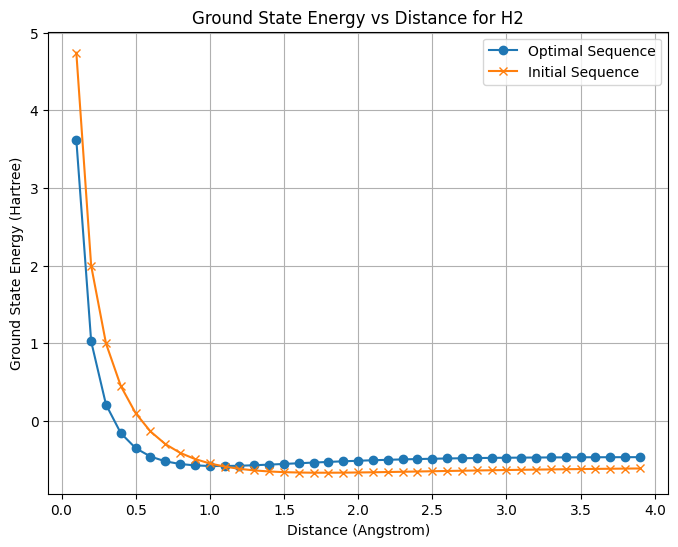

In [ ]:

# Define the initial sequence
initial_sequence = [
    (1,3),
    (5,1),
    (2,1,3),
    (6,2,1),
    (3,1),
    (2,1)
]
distances = np.arange(0.1,4,0.1)
optimal_energies = []
initial_energies = []
num_qubits = 4
ansatz = generate_circuit(num_qubits, initial_sequence)
vqe_solver = VQE(Estimator(), ansatz, SLSQP())
optimal_sequence = quantum_transformer(initial_sequence, hamiltonian_matrix, num_layers)
optimal_ansatz = generate_circuit(num_qubits, optimal_sequence)

for dist in distances:
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {dist}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    es_problem = driver.run()
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver1 = VQE(Estimator(), optimal_ansatz, SLSQP())
    num_particles = es_problem.num_particles
    num_spatial_orbitals = es_problem.num_spatial_orbitals
    num_qubits = num_spatial_orbitals * 2
    ansatz = generate_circuit(num_qubits, initial_sequence)
    calc = GroundStateEigensolver(converter, vqe_solver)
    res = calc.solve(es_problem)

    initial_energies.append(res.total_energies[0].real)

    calc1 = GroundStateEigensolver(converter, vqe_solver1)
    res1 = calc1.solve(es_problem)

    optimal_energies.append(res1.total_energies[0].real)


plt.figure(figsize=(8, 6))
plt.plot(distances, optimal_energies, marker='o', label='Optimal Sequence')
plt.plot(distances, initial_energies, marker='x', label='Initial Sequence')
plt.xlabel('Distance (Angstrom)')
plt.ylabel('Ground State Energy (Hartree)')
plt.title('Ground State Energy vs Distance for H2')
plt.legend()
plt.grid(True)
plt.show()